In [3]:
import os
import numpy as np
import pandas as pd
import pickle
import torch

import matplotlib.pyplot as plt

In [4]:
ckpt_path = "./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/predict_all_behavior/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25"
path = "./models/NF.15/Visnav_VR_Expt/lateral/Neuroformer/predict_all_behavior/(state_history=6,_state=6,_stimulus=6,_behavior=6,_self_att=6,_modalities=(n_behavior=25))/25/inference/results_trial_sample-True_top_p-0.95_top_p_t-0.95_temp-1.0_temp_t-1.0_frame_end-0_true_past-False_get_dt-True_gpu-True_pred_dt-True.pkl"

with open(path, 'rb') as f:
    results = pickle.load(f)

print(results.keys())

dict_keys(['true', 'ID', 'time', 'dt', 'Trial', 'Interval'])


In [7]:
for key in results.keys():
    if isinstance(results[key], list) and all(isinstance(i, (int, float)) for i in results[key]):
        print(key)
        results[key] = torch.tensor(results[key]).cpu().numpy()
results['true'] = np.array([float(i.cpu()) for i in results['true']])
# plot distribution of true and predicted values
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(results['true'], bins=100)
plt.title('True values')

plt.subplot(1, 2, 2)
plt.hist(results['ID'], bins=100)

AttributeError: 'numpy.float64' object has no attribute 'cpu'

In [8]:
len(results['ID'])
len(results['true'])

print(f"len ID: {len(results['ID'])}, len true: {len(results['true'])}")

len ID: 226104, len true: 344281


In [9]:
# print the frequency and ID of top 10 most frequent predictions

from collections import Counter

true_topk = Counter(results['true']).most_common(20)
pred_topk = Counter(results['ID']).most_common(20)

# data frame with true and predicted
df_topk = pd.DataFrame(true_topk, columns=['true', 'true_freq'])
df_topk['pred'] = [i[0] for i in pred_topk]
df_topk['pred_freq'] = [i[1] for i in pred_topk]
df_topk

# find common topk predictions
common_topk = []
for i in df_topk['true']:
    if i in df_topk['pred'].values:
        common_topk.append(i)

print(f"Common topk: {common_topk}")

Common topk: [2015.0, 1186.0, 1089.0, 1321.0, 258.0, 895.0]


In [10]:
# load_speed_predictions

speed_path = os.path.join(ckpt_path, 'inference', 'behavior_preds_speed.csv')
behavior_preds = pd.read_csv(speed_path)

In [11]:
behavior_preds

,Unnamed: 0,behavior_speed_value,interval,trial,true,cum_interval
0,0,0.691071,139.250000,0,0.096728,139.250000
1,1,1.395567,385.950012,0,1.042666,385.950012
2,2,-0.915597,1299.750000,0,1.450998,1299.750000
3,3,-1.455895,292.299988,0,-1.217890,292.299988
4,4,-1.473806,27.600000,0,0.090056,27.600000
...,...,...,...,...,...,...
26086,26086,-1.316943,640.700012,0,-0.171438,640.700012
26087,26087,-1.331049,1137.400024,0,-1.368525,1137.400024
26088,26088,-0.569313,34.200001,0,0.118744,34.200001
26089,26089,-1.517772,1132.250000,0,0.635988,1132.250000


/tmp/ipykernel_571692/4256559615.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(combined_limits, combined_limits, 'k--', color='red')
/tmp/ipykernel_571692/4256559615.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(combined_limits, combined_limits, 'k--', color='red')


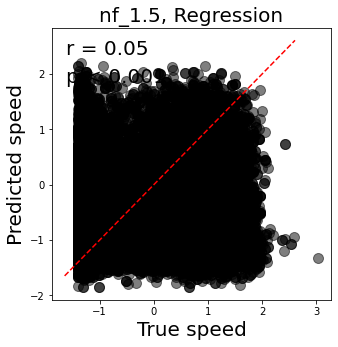

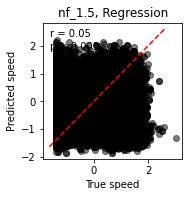

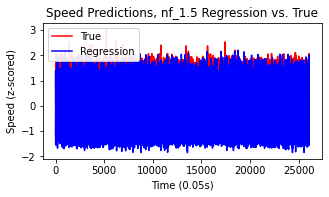

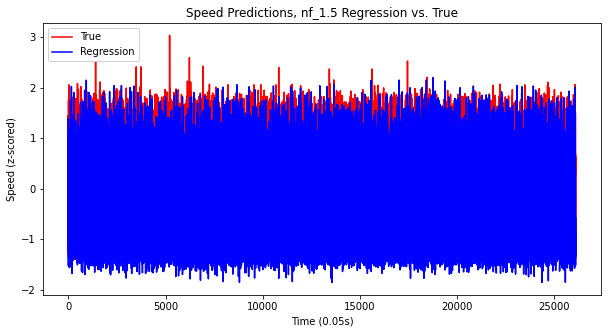

In [12]:
from scipy.stats import pearsonr
# from neuroformer.visualize import set_plot_params
# from neuroformer.visualize import set_research_params
model_name = "nf_1.5"



x_true, y_true = behavior_preds['cum_interval'], behavior_preds['true']
x_pred, y_pred = behavior_preds['cum_interval'], behavior_preds['behavior_speed_value']

# pearson r
r, p = pearsonr([float(y) for y in y_pred], [float(y) for y in y_true])

# plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_true, y_pred, s=100, c='k', alpha=0.5)

# get the current axis limits after plotting your data
xlims = ax.get_xlim()
ylims = ax.get_ylim()
s_f = 0.8
# the line of perfect prediction should span the minimum to the maximum of the current x and y limits
combined_limits = [min(xlims[0], ylims[0]) * s_f, max(xlims[1], ylims[1]) * s_f]
ax.plot(combined_limits, combined_limits, 'k--', color='red')

ax.set_xlabel('True speed', fontsize=20)
ax.set_ylabel('Predicted speed', fontsize=20)
ax.set_title(f'{model_name}, Regression', fontsize=20)
# add pearson r to figure
ax.text(0.05, 0.9, 'r = {:.2f}'.format(r), fontsize=20, transform=ax.transAxes)
# add p to figure
ax.text(0.05, 0.8, 'p < 0.001'.format(p), fontsize=20, transform=ax.transAxes)

# axis limits = [-1.5, 1.5]
# ax.set_xlim(axis_limits)
# ax.set_ylim(axis_limits)
# plt.savefig(os.path.join(save_path, 'regression_2.pdf'), dpi=300, bbox_inches='tight')


# plot
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.scatter(y_true, y_pred, c='k', alpha=0.5)

# get the current axis limits after plotting your data
xlims = ax.get_xlim()
ylims = ax.get_ylim()
s_f = 0.8
# the line of perfect prediction should span the minimum to the maximum of the current x and y limits
combined_limits = [min(xlims[0], ylims[0]) * s_f, max(xlims[1], ylims[1]) * s_f]
ax.plot(combined_limits, combined_limits, 'k--', color='red')

ax.set_xlabel('True speed',)
ax.set_ylabel('Predicted speed',)
ax.set_title(f'{model_name}, Regression',)
# add pearson r to figure
ax.text(0.05, 0.9, 'r = {:.2f}'.format(r), transform=ax.transAxes)
# add p to figure
ax.text(0.05, 0.8, 'p < 0.001'.format(p), transform=ax.transAxes)

# axis limits = [-1.5, 1.5]
# ax.set_xlim(axis_limits)
# ax.set_ylim(axis_limits)
# plt.savefig(os.path.join(save_path, 'regression_2.pdf'), dpi=300, bbox_inches='tight')


# %%
plt.figure(figsize=(5, 2.5))
x = np.arange(len(behavior_preds))
plt.title(f'Speed Predictions, {model_name} Regression vs. True')
plt.plot(x, y_true, c='r', label='True')
plt.plot(x, y_pred, c='b', label='Regression')
plt.xlabel('Time (0.05s)')
plt.ylabel('Speed (z-scored)')
plt.legend(loc='upper left', framealpha=0.9)
# plt.savefig(os.path.join(save_path, 'speed_preds.pdf'), bbox_inches='tight')


plt.figure(figsize=(10, 5))
x = np.arange(len(behavior_preds))
plt.title(f'Speed Predictions, {model_name} Regression vs. True')
plt.plot(x, y_true, c='r', label='True')
plt.plot(x, y_pred, c='b', label='Regression')
plt.xlabel('Time (0.05s)')
plt.ylabel('Speed (z-scored)')
plt.legend(loc='upper left', framealpha=0.9)